In [3]:
import numpy as np
import math
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, GlobalAveragePooling2D, Dropout

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

## Organization of Files Using OS

In [4]:
import os
import shutil

file_count_pos = len([name for name in os.listdir('C:/Users/matth/Desktop/images/CT_COVID/')])
file_count_neg = len([name for name in os.listdir('C:/Users/matth/Desktop/images/CT_NonCOVID/')])

train_size, val_size, test_size = .7, .15, .15

def split_img_data(label, train_size):
    val_size = test_size = (1 - train_size)/2
    
    file_count = len([name for name in os.listdir(f'C:/Users/matth/Desktop/images/{label}/')])
    dir_list = os.listdir(f'C:/Users/matth/Desktop/images/{label}/')
    
    train_idx = range(math.ceil(train_size * file_count))
    val_idx = range(math.ceil(train_size * file_count),math.ceil(train_size * file_count) + math.ceil(train_size+val_size * file_count))
    test_idx = range(math.ceil(train_size * file_count) + math.ceil(train_size+val_size * file_count), file_count)
    
    for i in train_idx:
        file_name = dir_list[i]
        os.rename(f'C:/Users/matth/Desktop/images/{label}/{file_name}',f'C:/Users/matth/Desktop/images/train/{label}/{file_name}')
        
    for i in val_idx:
        file_name = dir_list[i]
        os.rename(f'C:/Users/matth/Desktop/images/{label}/{file_name}',f'C:/Users/matth/Desktop/images/val/{label}/{file_name}')
        
    for i in test_idx:
        file_name = dir_list[i]
        os.rename(f'C:/Users/matth/Desktop/images/{label}/{file_name}',f'C:/Users/matth/Desktop/images/test/{label}/{file_name}')
    
    os.rmdir(f'C:/Users/matth/Desktop/images/{label}/')

In [ ]:
#split_img_data(label, .7) for label in ['ct_covid','ct_noncovid'] 

## Fetching Data

In [5]:
def retrieve_data(subset):
    img_array =[]
    class_name = []
    
    for label in os.listdir(f'C:/Users/matth/Desktop/Deep Learning/images/{subset}'):
        for file in os.listdir(f'C:/Users/matth/Desktop/Deep Learning/images/{subset}/{label}'):
            image = cv2.imread(f'C:/Users/matth/Desktop/Deep Learning/images/{subset}/{label}/{file}', 0)
            image = cv2.resize(image, (256,256))
            image = np.array(image).astype('float32')
            img_array.append(image)
            class_name.append(label)
            
    return img_array, class_name

In [6]:
X_train, y_train = retrieve_data('train')
X_val, y_val = retrieve_data('val')
X_test, y_test = retrieve_data('test')

In [7]:
train_data = image_dataset_from_directory(directory = 'C:/Users/matth/Desktop/Deep Learning/images/train', labels='inferred')
val_data = image_dataset_from_directory(directory = 'C:/Users/matth/Desktop/Deep Learning/images/val', labels='inferred')
test_data = image_dataset_from_directory(directory = 'C:/Users/matth/Desktop/Deep Learning/images/test', labels='inferred')

Found 523 files belonging to 2 classes.
Found 115 files belonging to 2 classes.
Found 108 files belonging to 2 classes.


## Baseline Random Forest Model

### PCA

In [8]:
def reshape_set(data):
    X_reshape = []
    
    for i in range(len(data)):
        X_reshape.append(data[i].reshape(len(data[i])** 2))
        
    return X_reshape

In [10]:
pca = PCA()

pca.fit(reshape_set(X_train))
X_train_pca = pca.transform(reshape_set(X_train))
X_test_pca = pca.transform(reshape_set(X_test))

placeholder

In [11]:
randomforest = RandomForestClassifier(n_estimators=100)

randomforest.fit(X_train_pca, y_train)

RandomForestClassifier()

In [12]:
randomforest.score(X_test_pca, y_test)

0.5185185185185185

## CNN

In [44]:
NN = Sequential()

NN.add(InputLayer(input_shape = (256, 256, 3)))

NN.add(Conv2D(filters = 8, kernel_size = 5, activation ='relu',padding = 'same'))
NN.add(Dropout(0.4))
NN.add(Conv2D(filters = 8, kernel_size = 5, activation ='relu',padding = 'same'))
NN.add(Dropout(0.4))
NN.add(MaxPooling2D())

NN.add(Conv2D(filters= 16, kernel_size=5, activation='relu', padding='same'))
# NN.add(Dropout(0.4))
# NN.add(Conv2D(filters= 16, kernel_size=5, activation='relu', padding='same'))
# NN.add(Dropout(0.4))
NN.add(MaxPooling2D())

NN.add(Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'))
NN.add(Dropout(0.4))
NN.add(Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'))
NN.add(Dropout(0.4))
NN.add(GlobalAveragePooling2D())

NN.add(Flatten())
NN.add(Dense(20, activation='relu'))
NN.add(Dense(1, activation='sigmoid'))  # 10 target classes


NN.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [45]:
NN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 256, 8)       608       
                                                                 
 dropout_18 (Dropout)        (None, 256, 256, 8)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 256, 256, 8)       1608      
                                                                 
 dropout_19 (Dropout)        (None, 256, 256, 8)       0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 8)      0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 16)      3216      
                                                      

In [46]:
NN.fit(train_data, epochs = 5, verbose = 1, validation_data = val_data)

Epoch 1/5
17/17 [==============================] - 28s 2s/step - loss: 1.9021 - accuracy: 0.5239 - val_loss: 0.6990 - val_accuracy: 0.4696
Epoch 2/5
 1/17 [>.............................] - ETA: 29s - loss: 0.6715 - accuracy: 0.6250

KeyboardInterrupt: 

In [27]:
NN.evaluate(test_data)

4/4 [==============================] - 0s 94ms/step - loss: 0.7861 - accuracy: 0.4167


[0.7861334681510925, 0.4166666567325592]

In [47]:
epoch_dict = {}
epochs = range(5, 21)
for epoch in epochs:
    NN.fit(train_data, epochs = epoch, verbose = 1, validation_data = val_data)
    epoch_dict[epoch] = NN.evaluate(test_data)[1]

Epoch 1/5
17/17 [==============================] - 27s 2s/step - loss: 0.6957 - accuracy: 0.5679 - val_loss: 0.6961 - val_accuracy: 0.4783
Epoch 2/5
17/17 [==============================] - 27s 2s/step - loss: 0.6792 - accuracy: 0.5526 - val_loss: 0.6960 - val_accuracy: 0.4522
Epoch 3/5
17/17 [==============================] - 27s 2s/step - loss: 0.6664 - accuracy: 0.5870 - val_loss: 0.6980 - val_accuracy: 0.4609
Epoch 4/5
17/17 [==============================] - 27s 2s/step - loss: 0.6554 - accuracy: 0.5755 - val_loss: 0.6992 - val_accuracy: 0.4261
Epoch 5/5
4/4 [==============================] - 1s 150ms/step - loss: 0.6939 - accuracy: 0.4352
Epoch 1/6
17/17 [==============================] - 27s 2s/step - loss: 0.6412 - accuracy: 0.6214 - val_loss: 0.6991 - val_accuracy: 0.4957
Epoch 2/6
17/17 [==============================] - 27s 2s/step - loss: 0.6271 - accuracy: 0.6367 - val_loss: 0.7029 - val_accuracy: 0.4261
Epoch 3/6
17/17 [==============================] - 27s 2s/step - loss

4/4 [==============================] - 1s 148ms/step - loss: 0.8130 - accuracy: 0.5370
Epoch 1/12
17/17 [==============================] - 27s 2s/step - loss: 0.3766 - accuracy: 0.8317 - val_loss: 1.2942 - val_accuracy: 0.5217
Epoch 2/12
17/17 [==============================] - 27s 2s/step - loss: 0.3410 - accuracy: 0.8356 - val_loss: 1.5209 - val_accuracy: 0.5130
Epoch 3/12
17/17 [==============================] - 27s 2s/step - loss: 0.3468 - accuracy: 0.8317 - val_loss: 1.6674 - val_accuracy: 0.5391
Epoch 4/12
17/17 [==============================] - 27s 2s/step - loss: 0.3643 - accuracy: 0.8451 - val_loss: 1.5978 - val_accuracy: 0.5304
Epoch 5/12
17/17 [==============================] - 27s 2s/step - loss: 0.3647 - accuracy: 0.8260 - val_loss: 1.5101 - val_accuracy: 0.4870
Epoch 6/12
17/17 [==============================] - 27s 2s/step - loss: 0.3313 - accuracy: 0.8566 - val_loss: 1.4410 - val_accuracy: 0.4957
Epoch 7/12
17/17 [==============================] - 27s 2s/step - loss: 0

17/17 [==============================] - 27s 2s/step - loss: 0.2547 - accuracy: 0.8776 - val_loss: 2.2715 - val_accuracy: 0.5043
Epoch 2/16
17/17 [==============================] - 27s 2s/step - loss: 0.2210 - accuracy: 0.9044 - val_loss: 2.1596 - val_accuracy: 0.4783
Epoch 3/16
17/17 [==============================] - 27s 2s/step - loss: 0.2237 - accuracy: 0.9082 - val_loss: 2.1415 - val_accuracy: 0.4696
Epoch 4/16
17/17 [==============================] - 27s 2s/step - loss: 0.2594 - accuracy: 0.8795 - val_loss: 1.7290 - val_accuracy: 0.5130
Epoch 5/16
17/17 [==============================] - 27s 2s/step - loss: 0.2544 - accuracy: 0.8795 - val_loss: 2.0823 - val_accuracy: 0.5478
Epoch 6/16
17/17 [==============================] - 27s 2s/step - loss: 0.2682 - accuracy: 0.8757 - val_loss: 2.1580 - val_accuracy: 0.4957
Epoch 7/16
17/17 [==============================] - 27s 2s/step - loss: 0.2463 - accuracy: 0.8948 - val_loss: 2.5900 - val_accuracy: 0.5565
Epoch 8/16
17/17 [=============

17/17 [==============================] - 27s 2s/step - loss: 0.1610 - accuracy: 0.9235 - val_loss: 3.6561 - val_accuracy: 0.4957
Epoch 7/19
17/17 [==============================] - 27s 2s/step - loss: 0.1353 - accuracy: 0.9407 - val_loss: 4.1008 - val_accuracy: 0.5565
Epoch 8/19
17/17 [==============================] - 27s 2s/step - loss: 0.3189 - accuracy: 0.8451 - val_loss: 2.4126 - val_accuracy: 0.5217
Epoch 9/19
17/17 [==============================] - 28s 2s/step - loss: 0.2816 - accuracy: 0.8834 - val_loss: 2.4053 - val_accuracy: 0.5217
Epoch 10/19
17/17 [==============================] - 27s 2s/step - loss: 0.2014 - accuracy: 0.9140 - val_loss: 2.7321 - val_accuracy: 0.5304
Epoch 11/19
17/17 [==============================] - 27s 2s/step - loss: 0.1709 - accuracy: 0.9235 - val_loss: 2.8734 - val_accuracy: 0.5217
Epoch 12/19
17/17 [==============================] - 28s 2s/step - loss: 0.1464 - accuracy: 0.9369 - val_loss: 3.6604 - val_accuracy: 0.5304
Epoch 13/19
17/17 [=========

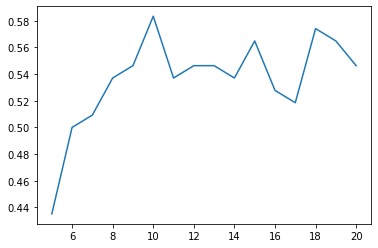

In [48]:
plt.plot(list(epoch_dict.keys()),list(epoch_dict.values()))